## COMP-553DL: Data Science for Bioinformatics and Medicine
## Programming Assignment 1 (Spring Semester 2025)
### Author: Ioannis Stathakis

####

### Part 3: Modeling/Validation Phase

#### Here we will experiment with training and validating of various models, so we can choose the best performing one.
#### I will separate this part into 4 subparts, each experimenting with classifiers for one of the four target variables consecutively.

####

### Target: Hinselmann

In [1]:
# Lets start with importing various modules and variables which will be necessary
# Core libraries
import pandas as pd
import numpy as np

# Modeling
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix, classification_report,
                             ConfusionMatrixDisplay, roc_curve)

# Resampling (for imbalance)
from imblearn.over_sampling import SMOTE

# Feature selection (optional)
from sklearn.feature_selection import RFECV

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


####

### Step 1: Loading and Preparing the respective Dataset

In [2]:
# Loading the Biopsy target modeling data
df = pd.read_csv("model_ready_hinselmann.csv")

# Separating features and target variable
X = df.drop(columns=["Hinselmann"])
y = df["Hinselmann"]

# Quick sanity check
print("Shape of X:", X.shape)
print("Target variable distribution:\n", y.value_counts(normalize=True))

Shape of X: (830, 7)
Target variable distribution:
 Hinselmann
0    0.957831
1    0.042169
Name: proportion, dtype: float64


####

### Step 2: Train/Test Split

In [3]:
# Using stratified split in order to preserve class balance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

####

### Step 3: Handling the target class imbalance using SMOTE algorithm

In [4]:
# This has to be done AFTER the train/test split
# Otherwise we will contaminate the test set with synthetic entries
# This is not advisable, especially in our case (medical data), because we want the test set to contain real world, clean entries

# Applying SMOTE to training data only
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Check the balance after the oversampling
print("After SMOTE:")
print(y_train_res.value_counts(normalize=True))

After SMOTE:
Hinselmann
0    0.5
1    0.5
Name: proportion, dtype: float64


####

### Step 4: Train Baseline Classifiers (Logistic Regression/Random Forest)

In [5]:
# We shall begin with default settings and two baseline models 
# This way we can quickly compare models and identify potential promising candidates
# Once we locate good-performing models, we can use GridSearchCV and Cross-Validation to further optimize hyperparameters

# Logistic Regression Model
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_res, y_train_res)

LogisticRegression(max_iter=1000, random_state=42)

In [6]:
# Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_res, y_train_res)

RandomForestClassifier(random_state=42)

####

### Step 5: Evaluate models on Test Set

In [7]:
# Since we are dealing with a heavily imbalanced set, Accuracy is not the best metric to rely on
# F1-Score, Recall (Sensitivity), ROC-AUC and Confusion Matrix are essential

# Creating a function for evaluation will be helpful
def evaluate_model(model, name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    print(f"\n{name} Evaluation:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    if y_proba is not None:
        print("ROC AUC:", roc_auc_score(y_test, y_proba))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))


In [8]:
# Run evaluations
evaluate_model(lr_model, "Logistic Regression")
evaluate_model(rf_model, "Random Forest")



Logistic Regression Evaluation:
Accuracy: 0.9518072289156626
Precision: 0.46153846153846156
Recall: 0.8571428571428571
F1 Score: 0.6
ROC AUC: 0.9797843665768194

Confusion Matrix:
[[152   7]
 [  1   6]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       159
           1       0.46      0.86      0.60         7

    accuracy                           0.95       166
   macro avg       0.73      0.91      0.79       166
weighted avg       0.97      0.95      0.96       166


Random Forest Evaluation:
Accuracy: 0.9578313253012049
Precision: 0.5
Recall: 0.7142857142857143
F1 Score: 0.5882352941176471
ROC AUC: 0.8539982030548068

Confusion Matrix:
[[154   5]
 [  2   5]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       159
           1       0.50      0.71      0.59         7

    accuracy                           0.96       166
   mac

In [9]:
# I will also add visualizations for various of the above metrics
# Again a function to achieve this will be very helpful
def visualize_model(model, name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4), facecolor="whitesmoke")
    sns.heatmap(cm, annot=True, fmt='d', cmap="YlOrBr", xticklabels=[0,1], yticklabels=[0,1])
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC-Curve
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.figure(figsize=(6, 4), facecolor="whitesmoke")
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_test, y_proba):.2f})")
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"{name} - ROC Curve")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Barplot of metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    metrics = {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1 Score': f1}
    plt.figure(figsize=(6, 4), facecolor="whitesmoke")
    ax = sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), hue=list(metrics.keys()), palette='copper', edgecolor="black")
    plt.ylim(0, 1)
    plt.title(f"{name} - Evaluation Metrics")
    plt.ylabel("Score")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Annotate bars with values
    for i, (metric, value) in enumerate(metrics.items()):
        ax.text(i, value / 2, f"{value:.2f}", ha='center', va='center', color="white", fontsize=10)
        
    plt.tight_layout()
    plt.show()


Logistic Regression Model Visualizations:



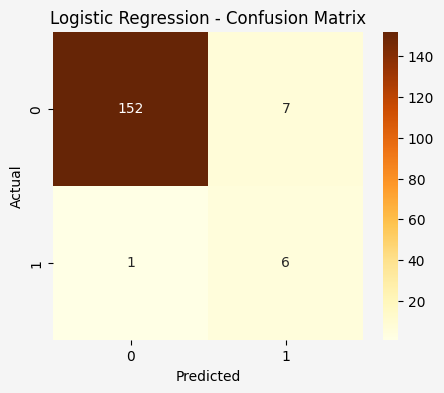

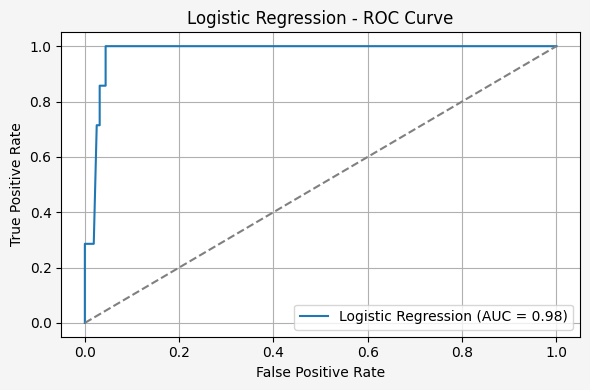

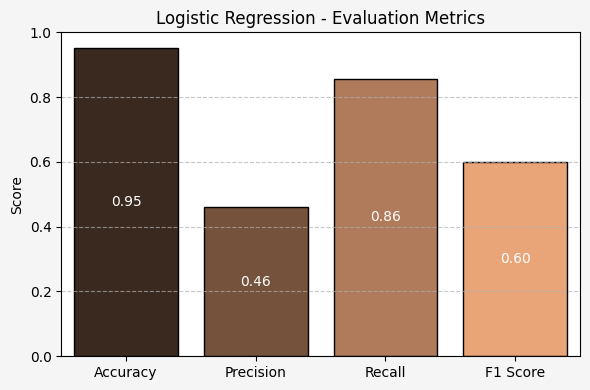


Random Forest Model Visualizations:



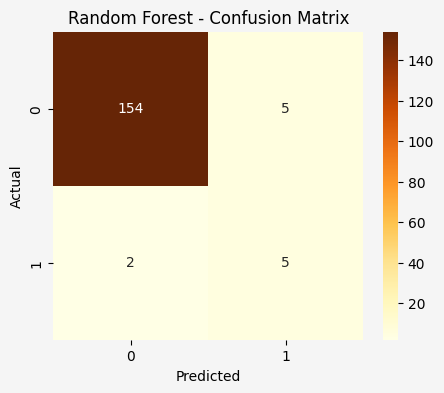

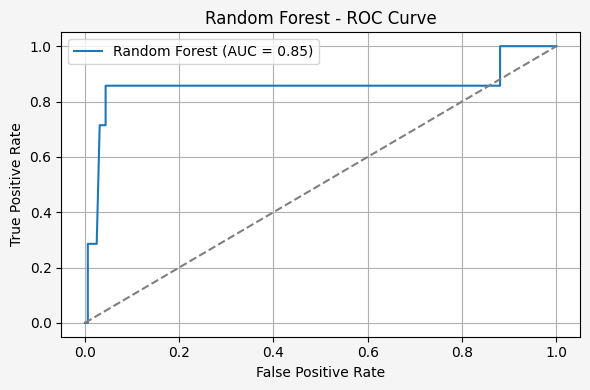

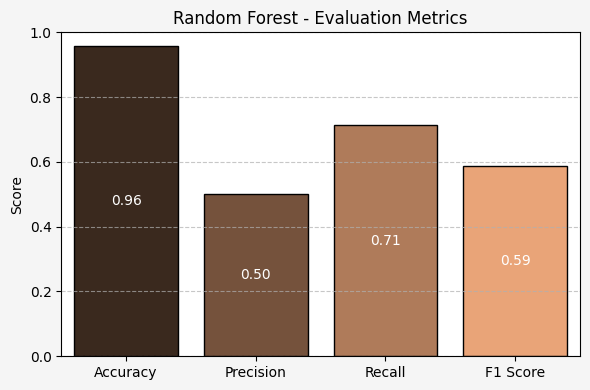

In [10]:
# Visualize both models
print("Logistic Regression Model Visualizations:\n")
visualize_model(lr_model, "Logistic Regression")
print()

print("Random Forest Model Visualizations:\n")
visualize_model(rf_model, "Random Forest")


####

### Step 6: Check For Overfitting

In [11]:
# This step is necessary for us to have a better idea of how the model is performing
# Compare Train vs Test Metrics (Logistic Regression)
print("Logistic Regression - Train/Test Comparison")

y_train_pred_lr = lr_model.predict(X_train)
y_test_pred_lr = lr_model.predict(X_test)

print("Train Accuracy:", accuracy_score(y_train, y_train_pred_lr))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_lr))
print("Train F1 Score:", f1_score(y_train, y_train_pred_lr))
print("Test F1 Score:", f1_score(y_test, y_test_pred_lr))
print("Train Recall:", recall_score(y_train, y_train_pred_lr))
print("Test Recall:", recall_score(y_test, y_test_pred_lr))

# Compare Train vs Test Metrics (Random Forest)
print("\nRandom Forest - Train/Test Comparison")

y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

print("Train Accuracy:", accuracy_score(y_train, y_train_pred_rf))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_rf))
print("Train F1 Score:", f1_score(y_train, y_train_pred_rf))
print("Test F1 Score:", f1_score(y_test, y_test_pred_rf))
print("Train Recall:", recall_score(y_train, y_train_pred_rf))
print("Test Recall:", recall_score(y_test, y_test_pred_rf))


Logistic Regression - Train/Test Comparison
Train Accuracy: 0.9503012048192772
Test Accuracy: 0.9518072289156626
Train F1 Score: 0.6206896551724138
Test F1 Score: 0.6
Train Recall: 0.9642857142857143
Test Recall: 0.8571428571428571

Random Forest - Train/Test Comparison
Train Accuracy: 0.9608433734939759
Test Accuracy: 0.9578313253012049
Train F1 Score: 0.675
Test F1 Score: 0.5882352941176471
Train Recall: 0.9642857142857143
Test Recall: 0.7142857142857143


In [12]:
# Learning Curve Visualization Functions for each of the most interesting metrics
def plot_learning_curve_f1(model, model_name):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring='f1', train_sizes=np.linspace(0.1, 1.0, 5), random_state=42
    )
    train_mean = train_scores.mean(axis=1)
    test_mean = test_scores.mean(axis=1)

    plt.figure(figsize=(6, 4))
    plt.plot(train_sizes, train_mean, label="Training F1", marker='o')
    plt.plot(train_sizes, test_mean, label="Validation F1", marker='o')
    plt.title(f"{model_name} - Learning Curve (F1 Score)")
    plt.xlabel("Training Set Size")
    plt.ylabel("F1 Score")
    plt.grid(True)
    plt.legend()
    plt.ylim(0, 1)
    plt.show()
    
def plot_learning_curve_precision(model, model_name):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring="precision", train_sizes=np.linspace(0.1, 1.0, 5), random_state=42
    )
    train_mean = train_scores.mean(axis=1)
    test_mean = test_scores.mean(axis=1)

    plt.figure(figsize=(6, 4))
    plt.plot(train_sizes, train_mean, label="Training Precision", marker='o')
    plt.plot(train_sizes, test_mean, label="Validation Precision", marker='o')
    plt.title(f"{model_name} - Learning Curve (Precision)")
    plt.xlabel("Training Set Size")
    plt.ylabel("Precision")
    plt.grid(True)
    plt.legend()
    plt.ylim(0, 1)
    plt.show()

def plot_learning_curve_accuracy(model, model_name):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring="accuracy", train_sizes=np.linspace(0.1, 1.0, 5), random_state=42
    )
    train_mean = train_scores.mean(axis=1)
    test_mean = test_scores.mean(axis=1)

    plt.figure(figsize=(6, 4))
    plt.plot(train_sizes, train_mean, label="Training Accuracy", marker='o')
    plt.plot(train_sizes, test_mean, label="Validation Accuracy", marker='o')
    plt.title(f"{model_name} - Learning Curve (Accuracy)")
    plt.xlabel("Training Set Size")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.ylim(0, 1)
    plt.show()
    
def plot_learning_curve_recall(model, model_name):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring="recall", train_sizes=np.linspace(0.1, 1.0, 5), random_state=42
    )
    train_mean = train_scores.mean(axis=1)
    test_mean = test_scores.mean(axis=1)

    plt.figure(figsize=(6, 4))
    plt.plot(train_sizes, train_mean, label="Training Recall", marker='o')
    plt.plot(train_sizes, test_mean, label="Validation Recall", marker='o')
    plt.title(f"{model_name} - Learning Curve (Recall)")
    plt.xlabel("Training Set Size")
    plt.ylabel("Recall")
    plt.grid(True)
    plt.legend()
    plt.ylim(0, 1)
    plt.show()
    
def plot_learning_curve_roc(model, model_name):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring="roc_auc", train_sizes=np.linspace(0.1, 1.0, 5), random_state=42
    )
    train_mean = train_scores.mean(axis=1)
    test_mean = test_scores.mean(axis=1)

    plt.figure(figsize=(6, 4))
    plt.plot(train_sizes, train_mean, label="Training ROC-AUC", marker='o')
    plt.plot(train_sizes, test_mean, label="Validation ROC-AUC", marker='o')
    plt.title(f"{model_name} - Learning Curve (ROC-AUC)")
    plt.xlabel("Training Set Size")
    plt.ylabel("ROC-AUC")
    plt.grid(True)
    plt.legend()
    plt.ylim(0, 1)
    plt.show()

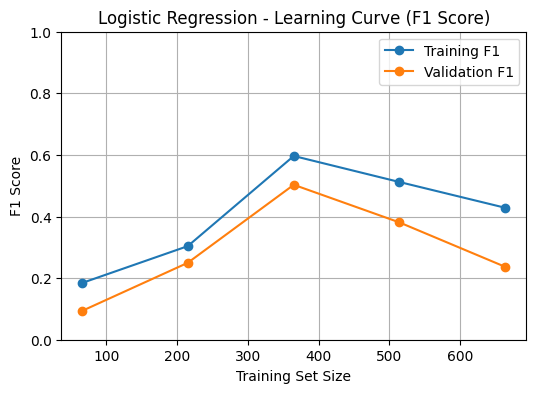

C:\Users\ska_p\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ska_p\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ska_p\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

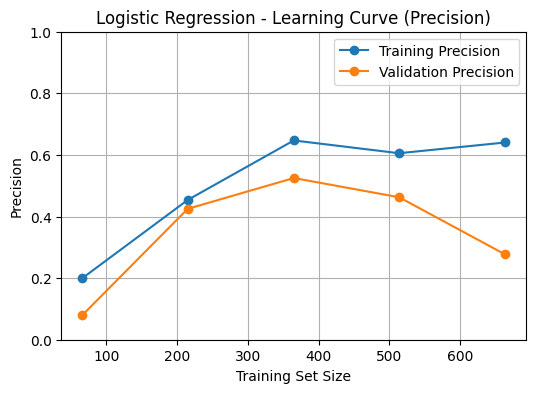

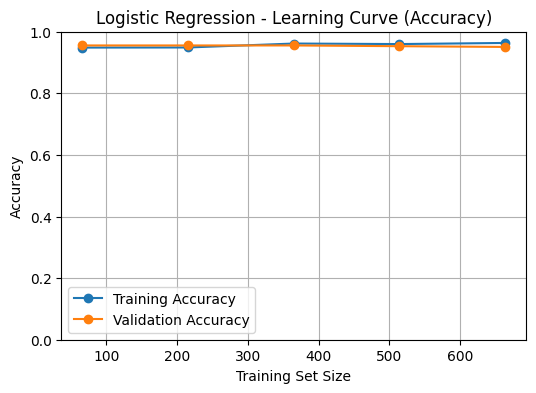

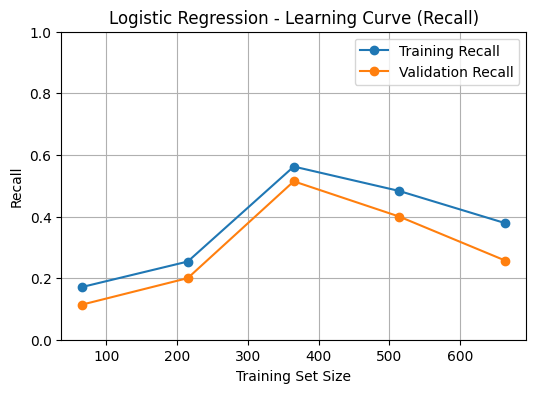

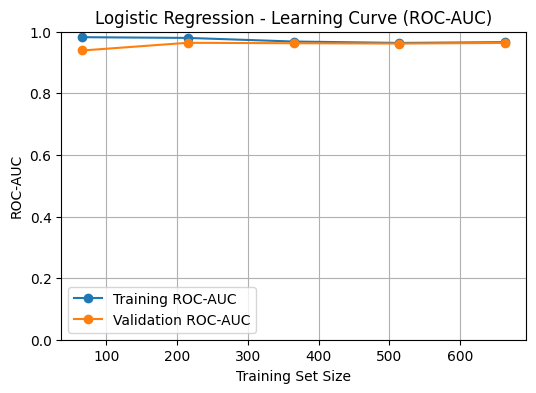

In [14]:
# Plot learning curves for the Logistic Regression Model
plot_learning_curve_f1(lr_model, "Logistic Regression")
plot_learning_curve_precision(lr_model, "Logistic Regression")
plot_learning_curve_accuracy(lr_model, "Logistic Regression")
plot_learning_curve_recall(lr_model, "Logistic Regression")
plot_learning_curve_roc(lr_model, "Logistic Regression")


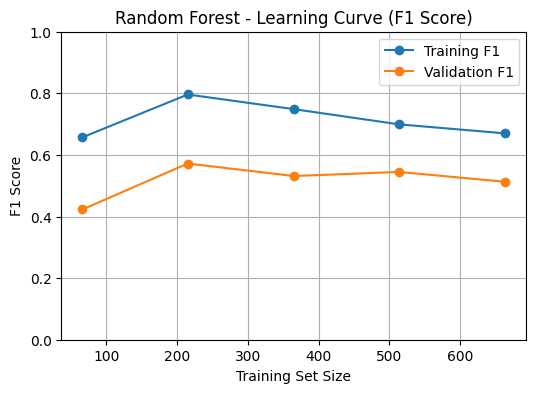

C:\Users\ska_p\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ska_p\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ska_p\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

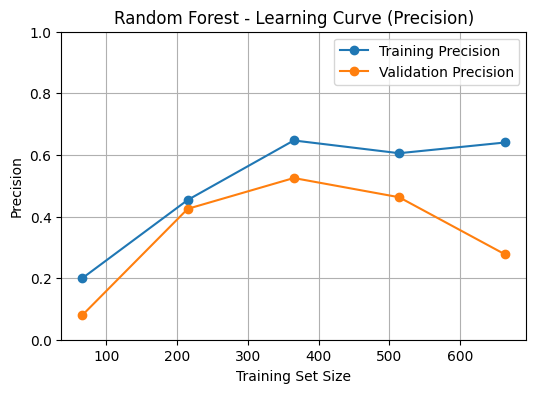

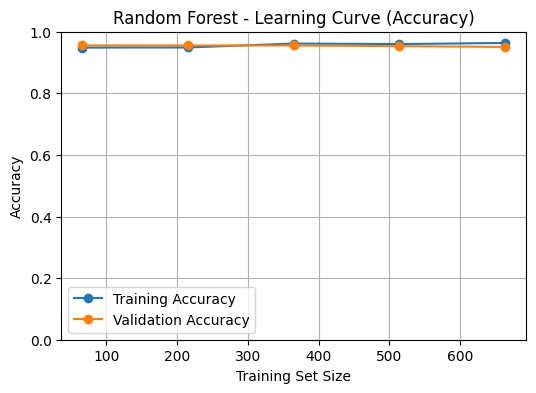

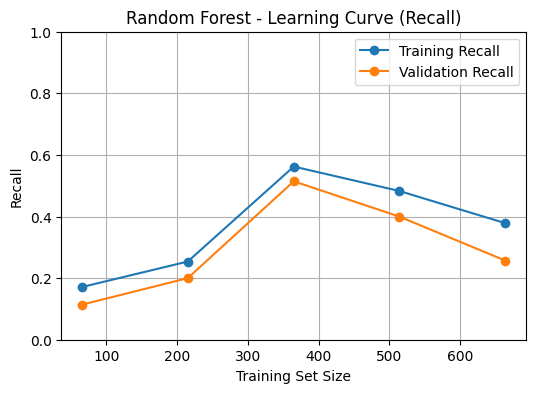

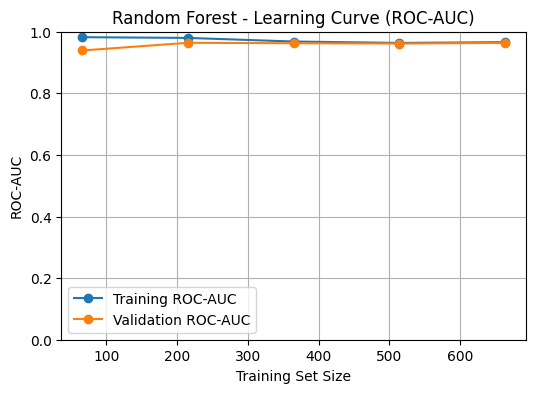

In [15]:
# Plot Learning Curves for the Random Forest Model
plot_learning_curve_f1(rf_model, "Random Forest")
plot_learning_curve_precision(lr_model, "Random Forest")
plot_learning_curve_accuracy(lr_model, "Random Forest")
plot_learning_curve_recall(lr_model, "Random Forest")
plot_learning_curve_roc(lr_model, "Random Forest")


####

####

#### Lets once again try training an XGBoost model as well, again in its default state and also using GridSearchCV tuning. 

In [16]:
from xgboost import XGBClassifier
# Using the same train/test sets we split earlier:
# Train XGBoost model
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_res, y_train_res)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)


XGBoost Evaluation:
Accuracy: 0.9578313253012049
Precision: 0.5
Recall: 0.7142857142857143
F1 Score: 0.5882352941176471
ROC AUC: 0.7362982929020665

Confusion Matrix:
[[154   5]
 [  2   5]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       159
           1       0.50      0.71      0.59         7

    accuracy                           0.96       166
   macro avg       0.74      0.84      0.78       166
weighted avg       0.97      0.96      0.96       166



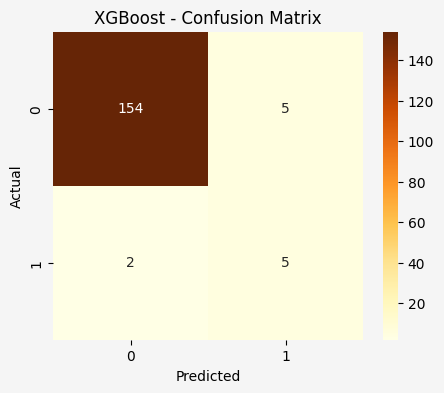

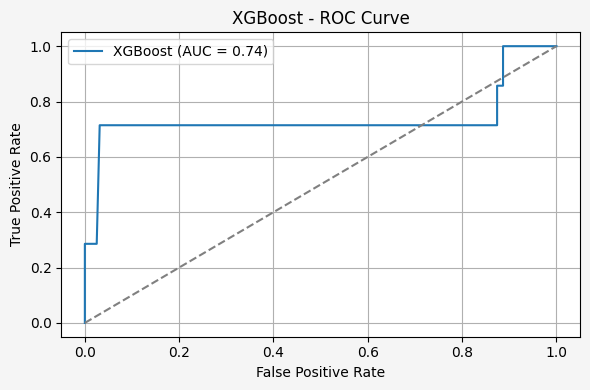

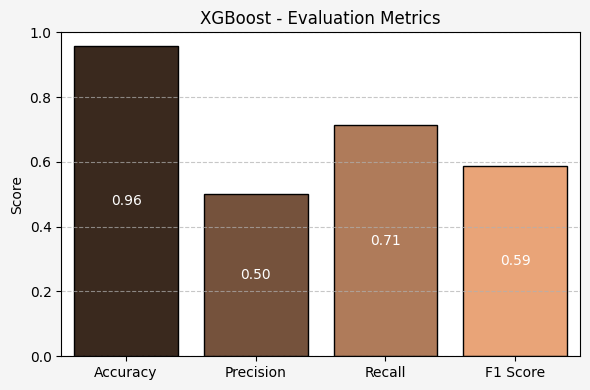

In [17]:
# Now I am going to use the evaluation/visualization functions I defined earlier, to check the performance of this model:
evaluate_model(xgb_model, "XGBoost")
visualize_model(xgb_model, "XGBoost")


####

#### Lets try to tune the XGBoost Model with GridSearchCV, and see if we get better results:

In [19]:
# Define the parameter grid with some basic hyperparameters (avoiding hugh computational expense)
param_grid = {"n_estimators": [50, 100], "max_depth": [3, 5], "learning_rate": [0.01, 0.1]}

# Grid search setup
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Run on SMOTE-resampled training set
grid_search.fit(X_train_res, y_train_res)

# Best model
best_xgb = grid_search.best_estimator_

# Print best params
print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}



XGBoost (Tuned) Evaluation:
Accuracy: 0.9578313253012049
Precision: 0.5
Recall: 0.7142857142857143
F1 Score: 0.5882352941176471
ROC AUC: 0.977088948787062

Confusion Matrix:
[[154   5]
 [  2   5]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       159
           1       0.50      0.71      0.59         7

    accuracy                           0.96       166
   macro avg       0.74      0.84      0.78       166
weighted avg       0.97      0.96      0.96       166



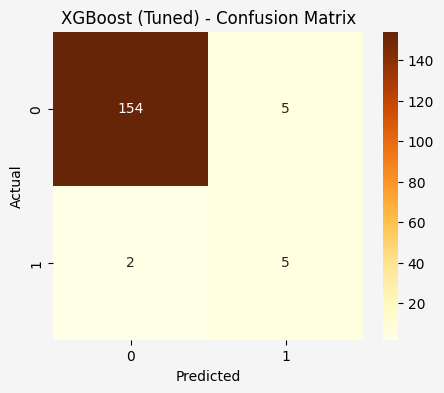

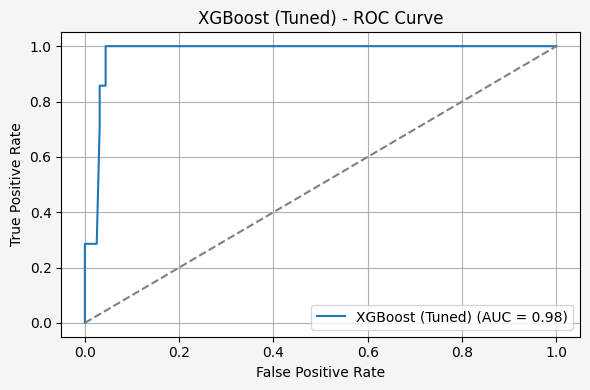

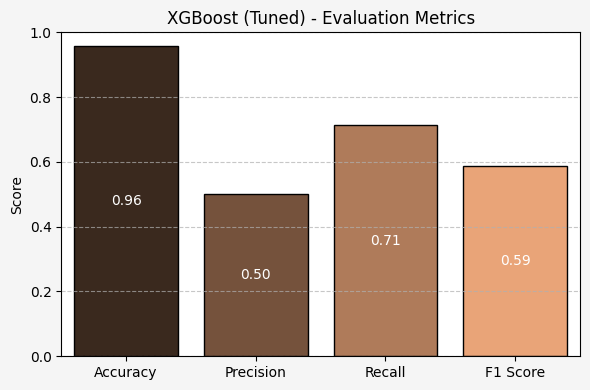

In [20]:
# Lets check the performance of the tuned model:
evaluate_model(best_xgb, "XGBoost (Tuned)")
visualize_model(best_xgb, "XGBoost (Tuned)")

#### 

### Some Key Observations / Final Decision:

#### <u>**Logistic Regression**<u>:
*Best F1 score (just slightly better than the others)*

*Best recall (0.86) — only 1 false negative*

*Best ROC AUC (0.98) — highly confident ranking of positive cases.*

*Maintains balanced simplicity + high performance.*

#### <u>**XGBoost (Tuned) and Random Forest**<u>:
*Match each other almost identically.*

*Both had 2 false negatives, and lower recall.*

*XGBoost ROC-AUC is back up (0.98) when tuned, but still no real performance gain over Logistic Regression.*


#### <u>Important Note: Sample Size<u>
Only 7 positive cases in the test set — this makes precision and F1 very sensitive to one or two misclassifications. 
Our recall of 0.86 with Logistic Regression (6/7 correct) is strong under this constraint.

####

#### <u>Final Decision for Hinselmann Target<u>:
**Logistic Regression**	would have to be the main choice, because of its highest recall, ROC-AUC, and cleanest balance of all metrics.
XGBoost (Tuned)	is probably optional runner-up if we want probabilistic backing.
The others show no clear benefit — can be safely skipped.